In [1]:
import numpy as np
import math
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import random

In [2]:
#Function to extract data from file
def getData(file_name):
    file_handle = open(file_name + ".txt", "r")
    lines = file_handle.readlines()
    gene_ids = []
    ground_truth_clusters = []
    input_matrix = []
    for line in lines:
        row = line.strip().split("\t")
        gene_ids.append(int(row.pop(0)))
        ground_truth_clusters.append(int(row.pop(0)))
        att_list=[float(i) for i in row]
        input_matrix.append(att_list)
    return np.array(gene_ids), np.array(ground_truth_clusters), np.array(input_matrix)

In [3]:
#Function to generate Affinity Matrix for each data point
def getAffinityMatrix(data, sigma):
    aff_mat = np.zeros((len(data), len(data)))
    dist = 0 
    for i in range(len(data)):
        for j in range(len(data)):
            dist = np.linalg.norm(data[i]-data[j])
            fdist = np.exp(-((dist**2)/(sigma**2)))
            aff_mat[i][j] = fdist
    return aff_mat

In [4]:
#Function to generate Degree Matrix
def getDegreeMatrix(affinity_matrix):
    D = []
    for i in range(len(affinity_matrix)):
        val=np.sum(affinity_matrix[i])-1.0
        D.append(val)
    return np.diag(D)

In [5]:
file_name = "new_dataset_1"
gene_ids, ground_truth_clusters, input_matrix = getData(file_name)

sigma = 0.5
aff_mat = getAffinityMatrix(input_matrix, sigma)
deg_mat = getDegreeMatrix(aff_mat)

#Calculate laplacian matrix
lap_mat = deg_mat - aff_mat

In [6]:
#lap_mat1 = np.linalg.inv(deg_mat) * lap_mat

In [7]:
#decompose laplacian matrix into eigen values and eigen vectors
eigen_values, eigen_vectors = np.linalg.eigh(lap_mat)

In [8]:
ev_sort = eigen_values.argsort()
eigen_values = eigen_values[ev_sort]
eigen_vectors = eigen_vectors[ev_sort]

In [9]:
#Function to get k value with maximum eigen gap
def max_eigen_gap(eigen_vals):
    num_clusters=-1
    val=0.0
    for i in range(1, len(eigen_vals)):
        if((np.subtract(eigen_vals[i],eigen_vals[i-1])>=val)):
            val = np.subtract(eigen_vals[i],eigen_vals[i-1])
            num_clusters=i+1
    return num_clusters

In [10]:
k_val = max_eigen_gap(eigen_values)

In [11]:
print("Max Eigen Gap found at index: ", k_val)

Max Eigen Gap found at index:  125


In [12]:
#Function to get data with reduced order according to k value
def getReducedVectors(k_value,eigen_vals, eigen_vecs):
    vectors = []
    for i in eigen_vals.argsort():
        vectors.append(eigen_vecs[i])
    return np.array(vectors)

In [13]:
reduced_data = getReducedVectors(k_val, eigen_values, eigen_vectors)

In [14]:
reduced_data = reduced_data[:,:k_val]

In [15]:
cluster_ids = [1,9,20]
initial_centroids=[]
for i in cluster_ids:
    initial_centroids.append(reduced_data[i-1].tolist())

In [16]:
# k = 5
# initial_centroids=[]
# for i in range(k):
#     initial_centroids.append(reduced_data[i].tolist())

In [17]:
#k-MEANS algorithm code
def kmeans(vectors, num_iterations, centroids):
    #print(centroids.shape)
    for z in range(num_iterations):
        cen_distances = []
        centdict = {}
        cluster_list=[]
        new_centroids = []
        for i in range(len(centroids)):
            centdict[i] = []
        for j in range(len(vectors)):
            distances = []
            for i in range(len(centroids)):
                dist = 0
                for k in range(len(vectors[j])):      
                    dist = dist + (centroids[i][k] - vectors[j][k])**2
                dist = math.sqrt(dist)
                distances.append(dist)        
            cent = distances.index(min(distances))
            values = centdict.get(cent)
            values.append(vectors[j])
            cluster_list.append(cent)
            centdict[cent]  = values
        for l in centdict.keys():
            data = np.array(centdict.get(l))
            new_centroids.append((np.average(data, axis=0)).tolist())
        if(new_centroids == centroids):
            print("Converging at iteration no.: ", z)
            centroids = new_centroids
            return np.array(centroids), cluster_list
        elif(z==num_iterations-1):
            print("Completed max iterations: ",z+1)
            centroids = new_centroids
            cluster_list=[]
            for j in range(len(vectors)):
                distances = []
                for i in range(len(centroids)):
                    dist = 0
                    for k in range(len(vectors[j])):      
                        dist = dist + (centroids[i][k] - vectors[j][k])**2
                    dist = math.sqrt(dist)
                    distances.append(dist)        
                cent = distances.index(min(distances))
                cluster_list.append(cent)
            return np.array(centroids), cluster_list
        centroids = new_centroids

In [18]:
max_iterations = 300
final_centroids, cluster_list = kmeans(reduced_data, max_iterations , initial_centroids)

Converging at iteration no.:  3


In [19]:
#Function to generate incidence matrices
def getIncidentMatrix(clusters):
    incident_mat=[]
    for i in range(len(clusters)):
        row_values = []
        val=0
        for j in range(len(clusters)):
            if(clusters[i]==clusters[j]):
                val=1
            row_values.append(val)
            val=0
        incident_mat.append(row_values)
    return incident_mat

In [20]:
ground_truth_incident = getIncidentMatrix(ground_truth_clusters)
    
cluster_list_incident = getIncidentMatrix(cluster_list)

In [21]:
#Function to calculate Rand and Jaccard values
def randAndJaccard(incident_ground_truth, incident_cluster_list):
    m00=0
    m01=0
    m10=0
    m11=0
    for i in range(len(incident_cluster_list)):
        for j in range(len(incident_cluster_list)):
            if(incident_cluster_list[i][j]==incident_ground_truth[i][j]):
                if(incident_cluster_list[i][j]==1):
                    m11=m11+1
                else:
                    m00=m00+1
            else:
                if(incident_cluster_list[i][j]==1):
                    m10=m10+1
                else:
                    m01=m01+1            

    rand = (m11+m00)/(m00+m11+m01+m10)
    jaccard = m11/(m11+m10+m01)
    return rand, jaccard

In [22]:
randID, jaccardCoeff = randAndJaccard(ground_truth_incident, cluster_list_incident)
print("Jaccard Coefficient:\t", jaccardCoeff)
print("Rand Index:\t\t", randID)

Jaccard Coefficient:	 0.37898089171974525
Rand Index:		 0.5666666666666667


In [23]:
#Function to generate data for PCA visualization
def generatePCAData(centroids, vectors):
    num_clusters = len(centroids)
    universal_list = []
#     for i in centroids:
#         universal_list.append(i.tolist())
    for i in vectors:
        universal_list.append(i.tolist())
    pca_data1 = PCA(n_components=2).fit_transform(universal_list)
    
    universal_list = []
    for i in centroids:
        universal_list.append(i.tolist())
    centroid_data = PCA(n_components=2).fit_transform(universal_list)
    
#     pca_data = pca_data1[num_clusters:,:]
#     centroid_data = pca_data1[0:num_clusters,:]
    
    return pca_data1, centroid_data

In [24]:
#Function to plot the data
def plotData(file_name, data,clusters,centroids):
    allcolors=[]
    for i in pltcolors.cnames.items():
        allcolors.append(i[0])
    plt.figure(figsize=(12,9))
    legend = list()
    classes = list(set(clusters))
    allcolors1 = ['red','deepskyblue','green','purple', 'brown', 'plum', 'darkcyan','blue','magenta','lightslategray','black','yellow','mediumpurple','cyan',]
    if(len(classes)>len(allcolors)):
        colors = [random.choice(allcolors) for i in range(len(classes))]
    else:
        colors = allcolors1
    for i in range(len(classes)):
        cluster_data = data[np.where(np.array(clusters) == classes[i])]
        legend.append(plt.scatter(cluster_data[:,0],cluster_data[:,1], c=colors[i], s=50, alpha=0.9))
        #plt.scatter(centroids[i][0],centroids[i][1], s=150, marker="x", c=colors[i], alpha = 0.9)
    plt.legend(legend,classes)
    plt.xlabel("Principle Component 1")
    plt.ylabel("Principle Component 2")
    plt.title("PCA visualization for Spectral Clustering and "+file_name+".txt file")
    plt.savefig('Spectral_'+file_name+'.png')
    plt.show()

In [25]:
#centroid_data = generatePCAData(final_centroids, k_kmeans)
pca_data1, centroid_data1 = generatePCAData(final_centroids, input_matrix)

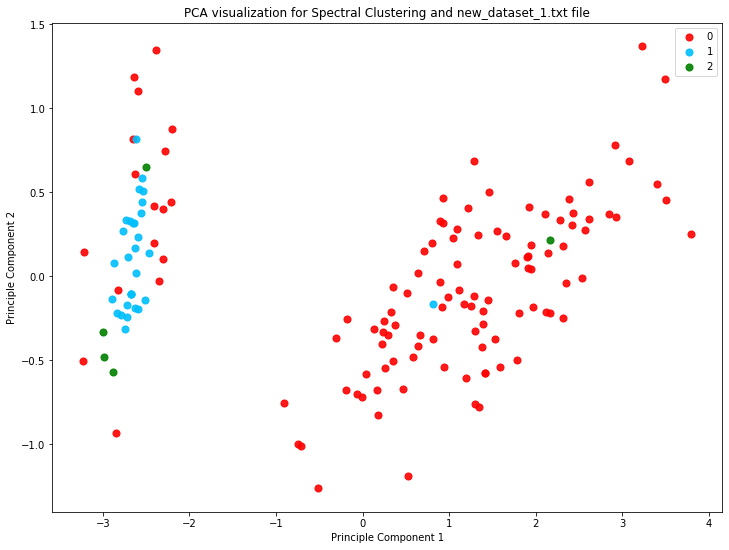

In [26]:
plotData(file_name, pca_data1, cluster_list, centroid_data1)

In [27]:
from sklearn.cluster import KMeans
k1 = KMeans(n_clusters = 3, init = np.array(initial_centroids), max_iter = 100).fit(reduced_data)

/home/hrishi/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [28]:
np.array_equal(np.array(cluster_list),k1.labels_)

True